# Problem 2 — Small Molecule Drug Discovery: Classical + Quantum (VQC) Comparison

This notebook implements a full workflow for a small-molecule drug-discovery binary classification task using:

- A classical baseline (SVM) on PCA features
- A Variational Quantum Classifier (VQC) implemented with Qiskit (no qiskit_machine_learning dependency)

Notes:

- The notebook uses a small synthetic DrugBank-like dataset (SMILES-like strings) and RDKit is not required.
- The quantum circuit evaluation uses `Statevector` simulation from Qiskit.
- This notebook is designed to run in Google Colab; run cells in order.


In [1]:

# Install / upgrade required packages
!pip install --quiet qiskit qiskit-aer pandas numpy scikit-learn matplotlib scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import ZZFeatureMap

from scipy.optimize import minimize

import time
print('Imports OK')


Imports OK


## Create a small synthetic DrugBank-like dataset (no RDKit required)

In [3]:

# Small synthetic dataset of SMILES-like strings with binary 'active' labels.
data = {
    'smiles': [
        'CCO','CCN','CCC','CCCl','C#N','c1ccccc1','CC(O)C','CC(=O)O','CCBr','C1=CC=CN=C1','CCS','CCF'
    ],
    'active': [1,0,0,1,0,1,1,0,1,1,0,0]
}
df = pd.DataFrame(data)
df.head()


,smiles,active
0,CCO,1
1,CCN,0
2,CCC,0
3,CCCl,1
4,C#N,0


## Feature engineering (RDKit-free)

In [4]:

def features_from_smiles(s):
    # simple, deterministic features extracted from SMILES text (no chemistry lib)
    return [
        len(s),                         # length
        sum(1 for c in s if c.isupper()),  # uppercase letters (approx heavy atoms)
        sum(1 for c in s if c.isdigit()),  # digits (rings)
        s.count('C'),                   # count of 'C' (carbons)
    ]

X = np.array([features_from_smiles(s) for s in df['smiles']])
y = df['active'].values

print('Feature matrix shape:', X.shape)
print('Feature matrix (first rows):\n', X[:4])


Feature matrix shape: (12, 4)
Feature matrix (first rows):
 [[3 3 0 2]
 [3 3 0 2]
 [3 3 0 3]
 [4 3 0 3]]


## Scale features and apply PCA (reduce to 4 components)

In [5]:

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (8, 4) Test shape: (4, 4)


## Classical baseline: SVM on PCA features

In [6]:

# Train classical SVM baseline
svm = SVC(kernel='rbf', gamma='scale')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
print('Classical SVM accuracy:', acc_svm)
print('\nClassification report (SVM):')
print(classification_report(y_test, y_pred_svm))


Classical SVM accuracy: 0.5

Classification report (SVM):
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.50      0.50      0.50         2

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.50         4
weighted avg       0.50      0.50      0.50         4



## Variational Quantum Classifier (VQC)

We build a parameterized circuit (feature encoding + ansatz) and train parameters by minimizing MSE between expectation value and label (-1,+1). The simulation uses Statevector from Qiskit. This implementation avoids qiskit_machine_learning. Training uses scipy.optimize.minimize (COBYLA).

In [7]:

n_qubits = 4

# Feature encoding: angle encoding using RX rotations for each component
def encoding_circuit(x):
    qc = QuantumCircuit(n_qubits)
    # assume x length == n_qubits
    for i, val in enumerate(x):
        qc.ry(val * np.pi, i)   # map feature in [0,1] to rotation
    return qc

# Variational ansatz: TwoLocal-like simple layered RY + CZ entanglement
def ansatz_circuit(params):
    qc = QuantumCircuit(n_qubits)
    # params length expected = n_qubits * n_layers
    n_layers = len(params) // n_qubits
    idx = 0
    for layer in range(n_layers):
        # single-qubit rotations
        for q in range(n_qubits):
            qc.ry(params[idx], q); idx += 1
        # entangling CZ chain
        for q in range(n_qubits-1):
            qc.cz(q, q+1)
    return qc

# Full circuit builder
def build_vqc_circuit(x, params):
    qc = QuantumCircuit(n_qubits)
    qc.compose(encoding_circuit(x), inplace=True)
    qc.compose(ansatz_circuit(params), inplace=True)
    return qc


In [8]:

# Expectation value of PauliZ on qubit 0 using statevector
def expectation_z0_from_statevector(statevector):
    # statevector.data is array of amplitudes in computational basis
    probs = np.abs(statevector.data)**2
    exp = 0.0
    for idx, p in enumerate(probs):
        # Determine bit value of qubit 0 (least significant bit in Qiskit ordering)
        # In Qiskit, basis state |q_{n-1} ... q_0> corresponds to index with q_0 as least significant bit.
        bit0 = idx & 1  # least-significant bit
        val = 1 if bit0 == 0 else -1  # Z: |0> -> +1, |1> -> -1
        exp += val * p
    return exp

# evaluate model prediction (expectation) for one sample
def vqc_predict_expectation(x, params):
    qc = build_vqc_circuit(x, params)
    sv = Statevector.from_instruction(qc)
    return expectation_z0_from_statevector(sv)


In [9]:

# Map labels 0/1 to -1/+1
y_train_signed = 2 * y_train - 1
y_test_signed = 2 * y_test - 1

# Training settings
n_layers = 2
n_params = n_qubits * n_layers
init_params = 0.1 * np.random.randn(n_params)

# Loss: mean squared error over small batch (all training samples here; data is tiny)
def loss_fn(params):
    preds = np.array([vqc_predict_expectation(x, params) for x in X_train])
    loss = np.mean((preds - y_train_signed)**2)
    return loss

# Callback to monitor
history = []
def callback_fn(xk):
    history.append(loss_fn(xk))

print('Initial loss:', loss_fn(init_params))

# Optimize using COBYLA via scipy.optimize.minimize
res = minimize(loss_fn, init_params, method='COBYLA', options={'maxiter': 200}, callback=callback_fn)
opt_params = res.x
print('Optimization success:', res.success, 'message:', res.message)
print('Final loss:', loss_fn(opt_params))


Initial loss: 1.9626081884072075
Optimization success: True message: Return from COBYLA because the trust region radius reaches its lower bound.
Final loss: 0.5469818053939894


In [10]:

# Evaluate VQC on test set
y_pred_q = np.array([1 if vqc_predict_expectation(x, opt_params) > 0 else 0 for x in X_test])
acc_q = accuracy_score(y_test, y_pred_q)
print('VQC accuracy:', acc_q)
print('\nClassification report (VQC):')
print(classification_report(y_test, y_pred_q))


VQC accuracy: 0.25

Classification report (VQC):
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.00      0.00      0.00         2

    accuracy                           0.25         4
   macro avg       0.17      0.25      0.20         4
weighted avg       0.17      0.25      0.20         4



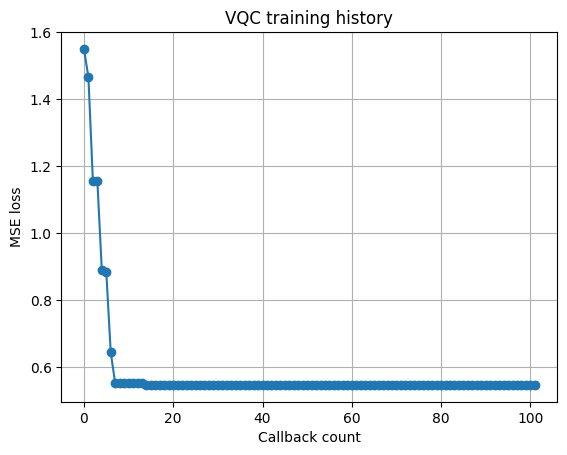

In [11]:

# Plot optimization history (loss)
plt.plot(history, '-o')
plt.xlabel('Callback count')
plt.ylabel('MSE loss')
plt.title('VQC training history')
plt.grid(True)
plt.show()
